# Predicting non-functional water pumps in Tanzania, Part I

This project is for a competition from [drivendata.org.](https://www.drivendata.org/competitions/7/)

Using data on water pumps in communities across Tanzania, can we predict the pumps that are functional, need repairs, or don't work at all?

The dataset contains a mix of continuous and categorical variables about what kind of pump is operating, when it was installed, how it was managed, etc. 

### Outline:  
#### Part I- EDA and cleanup
* The data  
* Visualizing water pumps and regions
* Dropping some features  
* Preprocessing labels  
* Looking at features  

#### Part II- Modeling
* Missing value imputation
* Model selection and evaluation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import pandas as pd
import numpy as np
import sys

import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import train_test_split, ShuffleSplit, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from IPython.core.display import display, HTML

rcParams['figure.figsize'] = 12, 4
print('Python version: %s.%s.%s' % sys.version_info[:3])
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sk.__version__)

Python version: 3.5.2
numpy version: 1.11.1
pandas version: 0.18.1
scikit-learn version: 0.18.1


/Users/jkim/anaconda/envs/py35/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Exploring the data

This dataset has 39 features. They are described [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#features_list).

In [24]:
# Load the data
train = pd.read_csv('training.csv', index_col='id')
labels = pd.read_csv('train_labels.csv', index_col='id')
test = pd.read_csv('test_set.csv', index_col='id')

In [25]:
train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,3/14/11,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,3/6/13,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2/25/13,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,0.0,1/28/13,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,0.0,7/13/11,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [26]:
print("Train data labels:",len(labels))
print("Train data rows, columns:",train.shape)
print("Test data rows, columns:", test.shape)

Train data labels: 59400
Train data rows, columns: (59400, 39)
Test data rows, columns: (14850, 39)


### Visualizing water pumps
We can use the longitude/latitude information to make a map showing water pumps by functional status (I used CARTO to make this map).


![See map](WellMap.png)

[Interactive Map](https://joomik.carto.com/builder/3227f55e-d6ac-11e6-832f-0e3ebc282e83/embed)

There is some "clumpiness" here; in the southeast near Mtwara and you'll notice that there seems to be a higher proportion of non-functional pumps (red) than near Makumbako (southwest), where you see a lot of green (functional). 

Apparently responsibility for water and sanitation service provision is decentralized, so local governments are responsible for water resource management.  Luckily, we have information on which regions the water pumps are in. Perhaps this will be a good predictor.

### Regions:

In [27]:
train.region.value_counts(dropna=False)

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

### Dropping some features

#### Subregions
In addition to the region feature, we have "subvillage" and "ward" features, which give more granular geographic information. These both have a lot of levels (19,287 and 2092, respectively).

Since we have broad regional data, I'm going to drop the more granular regional data for now in the interest of not having the number of features blow up. 
We do lose information by dropping this more granular regional data, and it may very well be that local powers have more of an impact on water pumps than the regional government (much like how a mayor can affect a city's sanitation more than a state's governor). So one thing I would do if I were to come back to this issue, is look more closely at the subvillages/wards. 

#### Features with many levels
While we're at it, I will drop the longitude/latitude for the same reasons as above, as well as the date_recorded feature, since I'm not interested in the temporal aspects for now. I'll also drop 'recorded_by' because every water pump had the same entry for this.

Lastly, there is a feature called wpt_name (name of the waterpoint if there is one) that has 37,400 levels (with the highest occurring level as "none"). I'll drop this too.

In [28]:
train.drop("date_recorded", axis=1, inplace=True)
train.drop("longitude", axis=1, inplace=True)
train.drop("latitude", axis=1, inplace=True)
train.drop("subvillage", axis=1, inplace=True)
train.drop("ward", axis=1, inplace=True)
train.drop("wpt_name", axis=1, inplace=True)
train.drop("recorded_by", axis=1, inplace=True)

### Label preprocessing
The labels are strings. We'll need to convert them to integers to make downstream machine learning easier

In [29]:
def label_map(y):
    """
    Converts string labels to integers
    """
    if y=="functional":
        return 2
    elif y=="functional needs repair":
        return 1
    else:
        return 0

In [30]:
# Labels for the training set (strings)
labels.head()

,status_group
id,
69572,functional
8776,functional
34310,functional
67743,non functional
19728,functional


In [31]:
labels = labels.applymap(label_map)
labels.head()

,status_group
id,
69572,2
8776,2
34310,2
67743,0
19728,2


In [32]:
labels.status_group.value_counts()

2    32259
0    22824
1     4317
Name: status_group, dtype: int64

Most wells are functional (label 2).

In [33]:
# Create a dataframe with features and labels merged
merged = pd.merge(train, labels, how='inner', left_index=True,right_index=True)

### Looking at features

First let's look at some of the continuous variables.

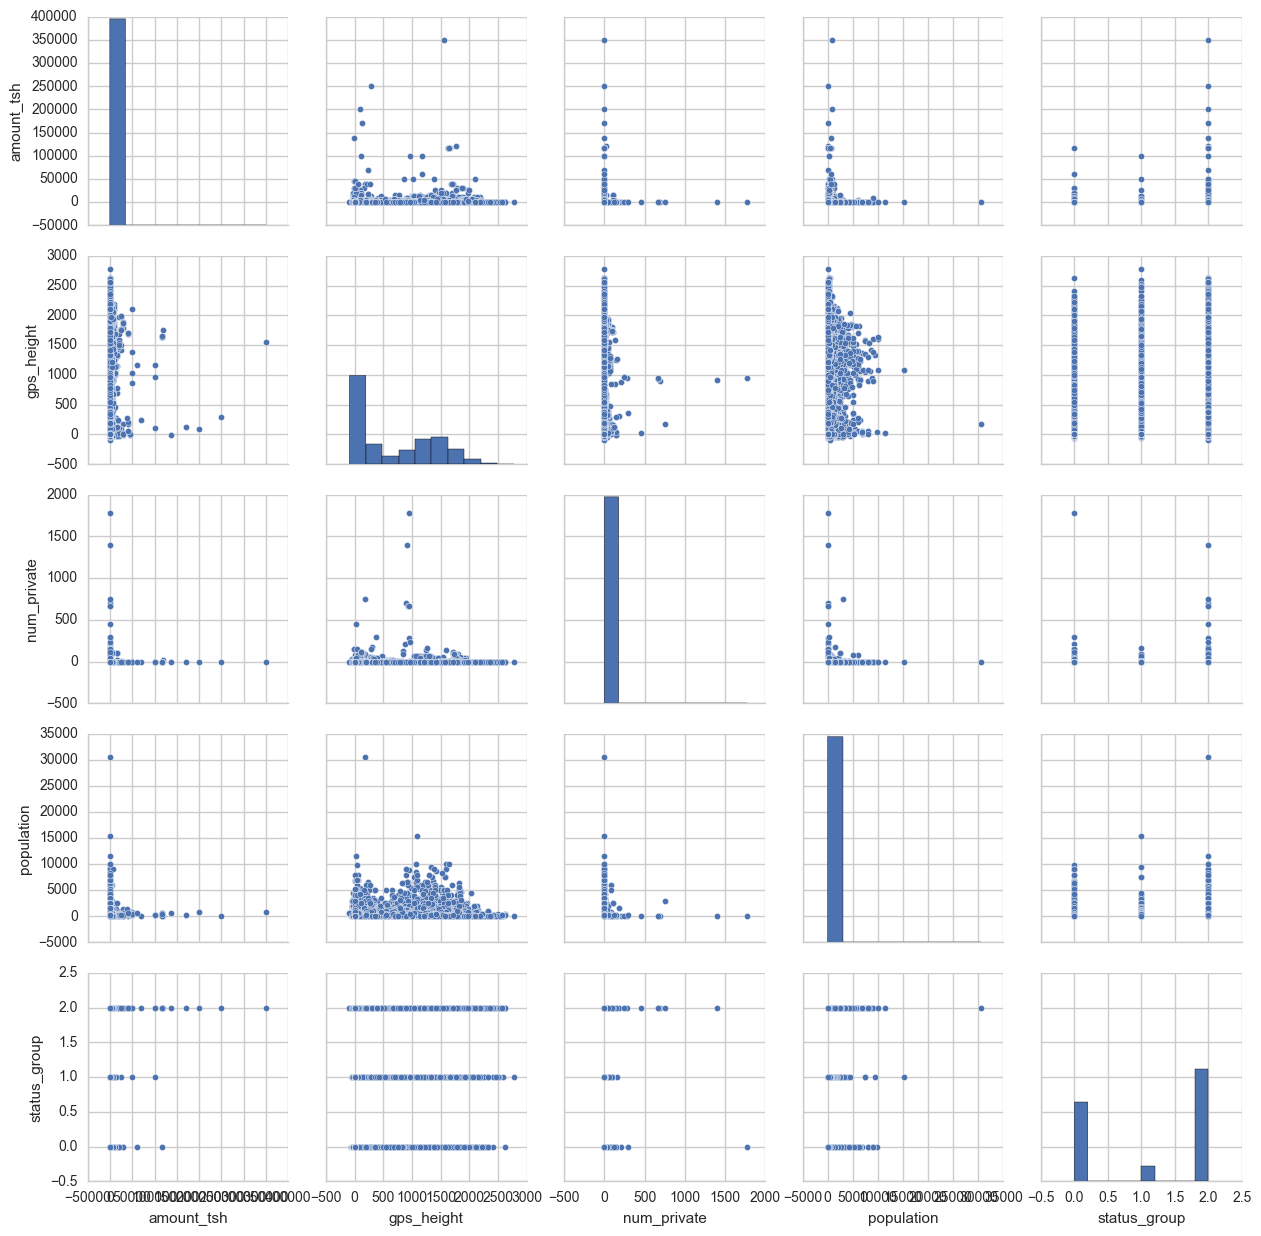

In [12]:
# Pairwise plots
sns.set(style='whitegrid',context='notebook')
cols=['amount_tsh','gps_height','num_private','population','status_group']
sns.pairplot(merged[cols],size=2.5)
plt.show()

The variables plotted here are:

- amount_tsh: total static head (amount water available to waterpoint)  
- gps_height: altitude of well  
- num_private: (this feature is not described)  
- population: population around the well

It looks like the water pumps with high static head tend to be functional (label 2). It would also be worth looking into whether the really high tsh values are realistic (aka, are these outliers just mistakes in data recording):

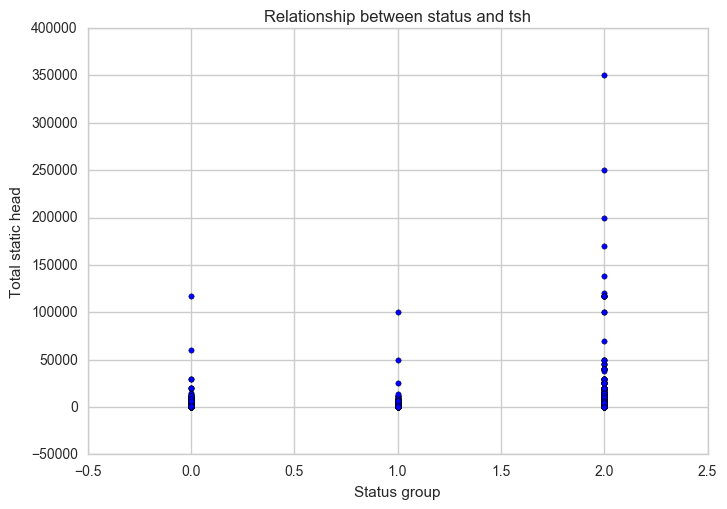

In [13]:
# Look at tsh
plt.scatter(merged.status_group, merged.amount_tsh, s=15)
plt.xlabel("Status group")
plt.ylabel("Total static head")
plt.title("Relationship between status and tsh")

#### Funders:

Apparently water resource management in Tanzania relies heavily on external donors (according to my rudimentary research). We have 1898 different funders in this dataset, with a lot of missing values. There are also many funders with too few observations to have any real impact on model fit (many funders that only occur once). 

In [34]:
len(train.funder.value_counts(dropna=False))

1898

In [35]:
train.funder.value_counts(dropna=False)

Government Of Tanzania            9084
NaN                               3636
Danida                            3114
Hesawa                            2202
Rwssp                             1374
World Bank                        1349
Kkkt                              1287
World Vision                      1246
Unicef                            1057
Tasaf                              877
District Council                   843
Dhv                                829
Private Individual                 826
Dwsp                               811
0                                  776
Norad                              765
Germany Republi                    610
Tcrs                               602
Ministry Of Water                  590
Water                              583
Dwe                                484
Netherlands                        470
Hifab                              450
Adb                                448
Lga                                442
Amref                    

In addition to the 3635 NaNs, there are 777 that have the entry "0".  
I'm assuming these are missing values too, so altogether we have 4412 missing values.


#### Some other problems with this data
A summary of other things to deal with in this dataset:

- installer: has NaNs, zeros, and many low frequency levels  
- scheme_name: has NaNs and many low frequency levels  
- scheme_management has NaNs
- population: has zeros and many low frequency levels*  
- construction_year: has zeros  
- permit: has NaNs  
- public_meeting: has NaNs  


#### Some options for dealing with this missing data 
1. Drop the rows (I don't want to do this because this would be a non-negligible proportion of the data and would lead to biased estimates if missing values are not missing at random).** 
2. Mean/median/mode imputation (crude, can severely distort the distribution of the variable).  
3. Predict (in order to do this, features need to be correlated or related somehow).
4. Create new feature like "no funder data." 


- For the missing categorical variables, I'm going to use option 4.  
- For the missing population, I'll leave the zeros as is, for the first pass at building a model, but at some point later on I might try to predict these using (for example) clustering or knn.  
- For the missing construction_year, I'll add a 'missing_construction_year' feature, and also run my model with and without imputation with the median. In a later iteration, maybe I'll try to impute using a fancier algorithmn.

#### * Note on population: 
If I were really thorough I would try to fill in missing population data using some kind of census data. Also I looked into using the (previously dropped) subvillage feature here to predict missing population values, but it does not seem like a good idea, because it appears that the population they report here (presumably some small radius around the water pump) is not just the subvillage population. That is, when I looked at population values for subvillages, entries with the same subvillage often had wildly different populations.  


#### ** Note on missing values: 
It's easy to imagine that some of these NaNs may not be missing at random (we can imagine that year info is missing more from older wells, for example), which is why dropping them is not the best idea. In practise sometimes this works out ok, so ideally I would try all these options and look at model performance with a GridSearchCV.

In [36]:
# Prep for imputation
# Convert the zeros in 'funder','installer', and 'population' to NaNs. 
merged_clean = merged.replace({'funder':0, 'installer':0, 'population':0}, np.nan)
merged_clean = merged.replace({'funder':'0', 'installer':'0'}, np.nan)

#### Dealing with low frequency/many levels
For these cases I will take low frequency levels (those that occur 20 times or less) and set to "other." The 20 here is totally arbitrary; in the interest of time I won't test out different thresholds or ways to bin, but ideally I would use cross validation to try out different methods and look at the effect on model performance. 

In [37]:
# Lump low frequency levels in funder, installer, scheme_name into 'other'
exempt=['amount_tsh',  'gps_height',  'num_private',
       'basin', 'region', 'region_code', 'district_code', 'lga', 'population',
       'public_meeting', 'scheme_management',  'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group']

merged_clean = merged_clean.apply(lambda x: x.mask(x.map(x.value_counts())<20, 'other') if x.name not in exempt else x)

#### Construction year  

Replace zeros with NaNs. 
It might also be a good idea to bin the construction_year feature, but I will leave it as it is for this first pass.

In [38]:
merged_clean = merged.replace({'construction_year':0}, np.nan)
merged_clean = merged.replace({'construction_year':'0'}, np.nan)

In [39]:
# Note: this changed year values to floats
merged_clean.construction_year.value_counts(dropna=False)

NaN        20709
 2010.0     2645
 2008.0     2613
 2009.0     2533
 2000.0     2091
 2007.0     1587
 2006.0     1471
 2003.0     1286
 2011.0     1256
 2004.0     1123
 2012.0     1084
 2002.0     1075
 1978.0     1037
 1995.0     1014
 2005.0     1011
 1999.0      979
 1998.0      966
 1990.0      954
 1985.0      945
 1980.0      811
 1996.0      811
 1984.0      779
 1982.0      744
 1994.0      738
 1972.0      708
 1974.0      676
 1997.0      644
 1992.0      640
 1993.0      608
 2001.0      540
 1988.0      521
 1983.0      488
 1975.0      437
 1986.0      434
 1976.0      414
 1970.0      411
 1991.0      324
 1989.0      316
 1987.0      302
 1981.0      238
 1977.0      202
 1979.0      192
 1973.0      184
 2013.0      176
 1971.0      145
 1960.0      102
 1967.0       88
 1963.0       85
 1968.0       77
 1969.0       59
 1964.0       40
 1962.0       30
 1961.0       21
 1965.0       19
 1966.0       17
Name: construction_year, dtype: int64

#### Adding feature for missing construction year data

In [40]:
# Function to test for Nan. Returns True for NaNs, False otherwise.
def isNan(num):
    return num != num

In [41]:
merged_clean['missing_construction_year'] = merged_clean['construction_year'].apply(lambda x: isNan(x))

In [42]:
merged_clean.head()

,amount_tsh,funder,gps_height,installer,num_private,basin,region,region_code,district_code,lga,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,missing_construction_year
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,Roman,1390,Roman,0,Lake Nyasa,Iringa,11,5,Ludewa,...,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2,False
8776,0.0,Grumeti,1399,GRUMETI,0,Lake Victoria,Mara,20,2,Serengeti,...,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2,False
34310,25.0,Lottery Club,686,World vision,0,Pangani,Manyara,21,4,Simanjiro,...,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2,False
67743,0.0,Unicef,263,UNICEF,0,Ruvuma / Southern Coast,Mtwara,90,63,Nanyumbu,...,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0,False
19728,0.0,Action In A,0,Artisan,0,Lake Victoria,Kagera,18,1,Karagwe,...,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2,True


#### Summary of the number of missing values for each column

In [43]:
merged_clean.isnull().sum()

amount_tsh                       0
funder                        3636
gps_height                       0
installer                     3656
num_private                      0
basin                            0
region                           0
region_code                      0
district_code                    0
lga                              0
population                       0
public_meeting                3334
scheme_management             3877
scheme_name                  28166
permit                        3056
construction_year            20709
extraction_type                  0
extraction_type_group            0
extraction_type_class            0
management                       0
management_group                 0
payment                          0
payment_type                     0
water_quality                    0
quality_group                    0
quantity                         0
quantity_group                   0
source                           0
source_type         

Interesting to note that the number of NaNs for both the funder and installer columns is close. If we compare just these two columns we see that the NaNs often appear in the same rows:

In [44]:
pd.concat([merged_clean.funder, merged_clean.installer], axis=1)

,funder,installer
id,,
69572,Roman,Roman
8776,Grumeti,GRUMETI
34310,Lottery Club,World vision
67743,Unicef,UNICEF
19728,Action In A,Artisan
9944,Mkinga Distric Coun,DWE
19816,Dwsp,DWSP
54551,Rwssp,DWE
53934,Wateraid,Water Aid


Something to notice here: the funder and installer is often the same entitiy.  

When they are not the same, it's usually because 'DWE' appears as the installer. It seems like 'DWE' could be some code for something (like "no information"), instead of an actual installer. Anyway, I will leave these alone in the absence of more information on what the acronyms mean.  

Also there are some cases where the same entitiy was probably entered differently- for example "Danida" and "Danid" or "Jaica" and "JAICA CO" or "Government of Tanzania" and "Government" or "Wateraid" and "Water Aid" I won't try to fix these for now, but this is something one would do ideally.

### Dealing with categorical variables.
Convert categorical variables into dummy/indicator variables. At the same time, we'll be adding columns to indicate NaNs. 

In [46]:
merged_clean_dum = pd.get_dummies(merged_clean, dummy_na=True)

In [47]:
merged_clean_dum.head()

,amount_tsh,gps_height,num_private,region_code,district_code,population,construction_year,status_group,missing_construction_year,funder_0,...,waterpoint_type_improved spring,waterpoint_type_other,waterpoint_type_nan,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other,waterpoint_type_group_nan
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,1390,0,11,5,109,1999.0,2,False,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8776,0.0,1399,0,20,2,280,2010.0,2,False,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
34310,25.0,686,0,21,4,250,2009.0,2,False,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
67743,0.0,263,0,90,63,58,1986.0,0,False,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
19728,0.0,0,0,18,1,0,NaN,2,True,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [48]:
merged_clean_dum.shape

(59400, 7069)

I now have 7069 features.

In [50]:
merged_clean_dum.to_csv('merged_clean_dum.csv')

### A note on other features of interest  for this project
It's easy to imagine that we could improve our predictions with other sources of (public) data here. Some that come to mind in this case are:  
- Presence of other utilities  
- Rate of previous breakdowns  
- Distance to major road  
- Whether the water pump is in a hazardous or flooding area
- Crime rate in the near vicinity  

### Up next:
For Part II - dealing with missing values + model selection and evalualtion